# Regression, object shape recognition and counting

In this final part of the assignment, we will test how well can deep networks adapt to  different (more interesting!) tasks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
# I had to add this due to error
# OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Part 1 - Counting stars

In this first part, you will train a network to count the number of stars contained in an image. We will try to make this slightly more interesting: instead of having one specific class for each number of objects, we will train the network to output a real number -- therefore we will be doing regression instead of categorical classification. 

### 1.1 Load the dataset

In [3]:
x_train = np.load('Q6_1_x_train.npy')
y_train = np.load('Q6_1_y_train.npy')

x_test = np.load('Q6_1_x_test.npy')
y_test = np.load('Q6_1_y_test.npy')

In [4]:
N_test = x_test.shape[0]
N_train = x_train.shape[0]

img_shape_full = x_train.shape[1:]# (height, width, n_channels)
print(N_train,N_test,img_shape_full)

12000 5000 (64, 64, 1)


Notice that, to makes things harder for the network, __we will omit one of the classes (3) from the training set!__ See below for youself:

In [5]:
train_classes = np.unique(y_train)
n_train_classes = len(train_classes)
print('Train classes:',train_classes)
test_classes = np.unique(y_test)
n_test_classes = len(test_classes)
print('Test classes:',test_classes)


Train classes: [1. 2. 4. 5.]
Test classes: [1. 2. 3. 4. 5.]


__Q. To familiarize yourself with the dataset, plot a few examples of each class. The class number corresponds to the number of objects in the image.__

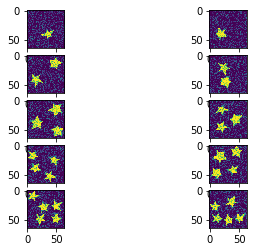

In [7]:
# YOUR CODE HERE

plt.subplot(5, 2, 1)
plt.imshow(np.reshape(x_test[0], (64, 64)))
plt.subplot(5, 2, 2)
plt.imshow(np.reshape(x_test[1], (64, 64)))
plt.subplot(5, 2, 3)
plt.imshow(np.reshape(x_test[1005], (64, 64)))
plt.subplot(5, 2, 4)
plt.imshow(np.reshape(x_test[1006], (64, 64)))
plt.subplot(5, 2, 5)
plt.imshow(np.reshape(x_test[2000], (64, 64)))
plt.subplot(5, 2, 6)
plt.imshow(np.reshape(x_test[2001], (64, 64)))
plt.subplot(5, 2, 7)
plt.imshow(np.reshape(x_test[3010], (64, 64)))
plt.subplot(5, 2, 8)
plt.imshow(np.reshape(x_test[3012], (64, 64)))
plt.subplot(5, 2, 9)
plt.imshow(np.reshape(x_test[4020], (64, 64)))
plt.subplot(5, 2, 10)
plt.imshow(np.reshape(x_test[4025], (64, 64)))


Before you proceed, think about whether you expect this task to be even possible: can a network generalize to examples it has never seen before? Can you think of a way solve this problem without using a deep network? Would it be easy or hard?

A network cannot really generalize to examples it has never seen before. This is because the y vector in the training examples does not even have the corresponding answer. In my opinion, it would be good to use a tree that contains the possible categories with data on different features, and look at how examples never seen before take in the features. In this way we could generalize to more classes. 

### 1.2 Build and train the model

Let's build our network now. Observe how we define the final __regression layer__.

In [8]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv1', input_shape=img_shape_full))

model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

# To do regression, use a linear activation for the final dense layer!
model.add(Dense(1, activation='linear'))



Instructions for updating:
Colocations handled automatically by placer.


We cannot use `categorical_cross_entropy` here for the loss; we must use some kind of function that computes the difference in numerical value between the network's output and the actual desired value. Two examples: mean squared error, mean absolute error.

In [9]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

Instructions for updating:
Use tf.cast instead.


In [10]:
model.fit(x=x_train,
          y=y_train,
          epochs=3, batch_size=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
12000/12000 [==============================] - 50s 4ms/sample - loss: 54.5658 - mean_absolute_error: 2.0730
Epoch 2/3
12000/12000 [==============================] - 42s 4ms/sample - loss: 0.1805 - mean_absolute_error: 0.3254
Epoch 3/3
12000/12000 [==============================] - 45s 4ms/sample - loss: 0.0929 - mean_absolute_error: 0.2327


### 1.3 Evaluate results

It seems to have brought the train error considerably down (make sure you get a MAE below 0.5!). Let's see how it does with the test set now:

In [11]:
result = model.evaluate(x=x_test,
                        y=y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

5000/5000 [==============================] - 6s 1ms/sample - loss: 0.0971 - mean_absolute_error: 0.2394
loss 0.09713682389259339
mean_absolute_error 0.23937339


The mean error looks small! But... is it really giving reasonable answers for the cases with 3 objects? Let's check the network's prediction for each class by plotting a histogram of all outputs for each class in the test set.

Class 0 mae 0.13318506956100465


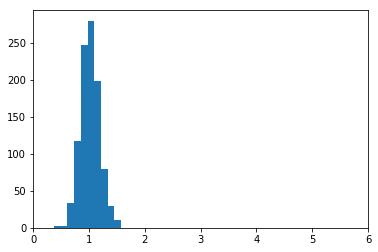

Class 1 mae 0.20271783888339998


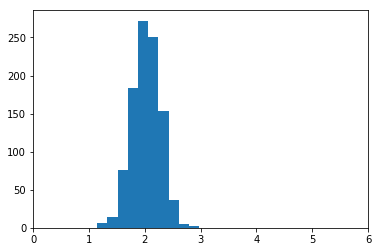

Class 2 mae 0.26401552200317385


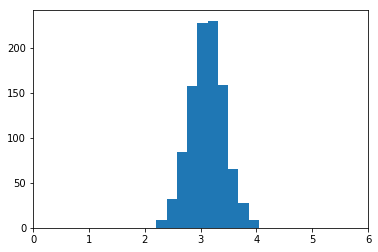

Class 3 mae 0.2696214184761047


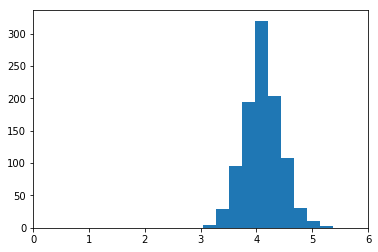

Class 4 mae 0.3273271040916443


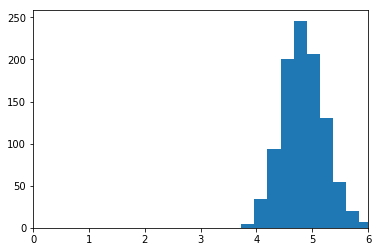

In [12]:
# check the network's prediction for each class

pts_per_class = 1000

for c in range(n_test_classes):

    predx = x_test[c*1000:(c+1)*1000]
    predy = model.predict(x=predx)

    # printout class name and MAE (mean abs. error) specific to this class
    print("Class",c,"mae",np.abs(predy-y_test[c*1000:(c+1)*1000]).mean())
    # plto histogram of outputs for this
    plt.hist(predy)
    plt.xlim([0,6])
    plt.show() #display current plot

__Q. Is this what you expected? Comment on the results.__

It is what I expected. The model predicts each class with correctness while having some errors that basically distribute like gaussians

__Q. Note that this was not a typical regression scenario, since we actually _do_ have discrete classes given by the number of stars. (We mainly used regression here in order test the network capabilities for extrapolating its "counting ability" to a never-before-seen number of stars. That wouldn't have worked using one-hot y vectors -- why?)__

__Therefore, we could compute the accuracy in a different way: if we consider the categorical output to be the closest integer to ther number output by the network, what would be the % of correctly classified test inputs? (Hint: use__ `np.round` __on the model predictions and compare with the integers in__ `y_test`__.)__

Class 0 mae 0.008


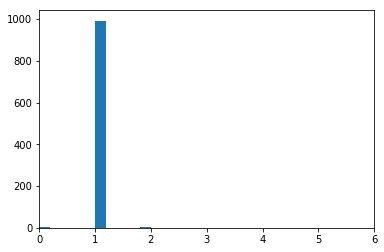

Class 1 mae 0.042


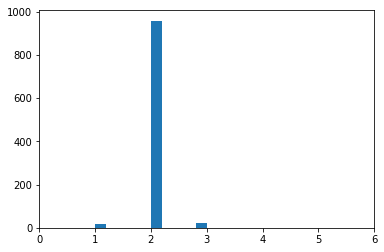

Class 2 mae 0.123


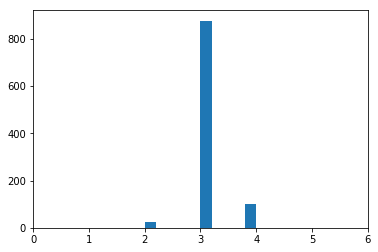

Class 3 mae 0.144


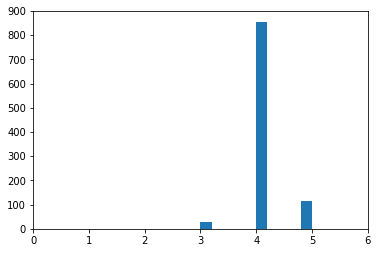

Class 4 mae 0.232


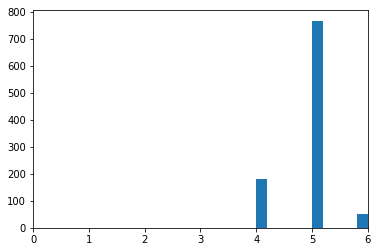

In [13]:
# YOUR ANSWER HERE
# Because one hot vectors are expanded into different dimensions for categorical purposes and do not have the counting ability


# check the network's prediction for each class

pts_per_class = 1000

for c in range(n_test_classes):

    predx = x_test[c*1000:(c+1)*1000]
    predy = np.round(model.predict(x=predx))

    # printout class name and MAE (mean abs. error) specific to this class
    print("Class",c,"mae",np.abs(predy-y_test[c*1000:(c+1)*1000]).mean())
    # plto histogram of outputs for this
    plt.hist(predy)
    plt.xlim([0,6])
    plt.show() #display current plot


__Q. Try to use the visualization techniques discussed before on this network's weights and layer outputs. Is it possible to gain some insight on how this network is able to count the number of objects?__

It is possible to gain some insight on how this network is able to count the number of objects. The filters just basically visualize the numbers of stars for each layer



## Part 2 - Counting star tips

The dataset now consists of a single "pointy, star-like object", and you will see if you can train a network to count the number of tips each object has. The objects range from 3- to 7-pointed stars.

### 2.1 Load the dataset

In [14]:
x_train = np.load('Q6_2_x_train.npy') #5 classes, 3000 examples per class
y_train = np.load('Q6_2_y_train.npy')

x_test = np.load('Q6_2_x_test.npy') #5 classes, 1000 examples per class
y_test = np.load('Q6_2_y_test.npy')

N_test = x_test.shape[0]
N_train = x_train.shape[0]

img_shape_full = x_train.shape[1:]# (height, width, n_channels)
print(N_train,N_test,img_shape_full)

15000 5000 (64, 64, 1)


In [15]:
#convert to one-hot y's
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

__Q. To familiarize yourself with the dataset, plot a few examples of each class. The class number corresponds to the number of tips in the object.__

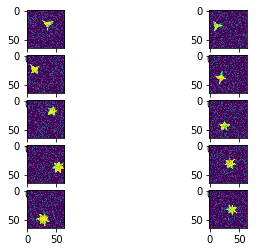

In [16]:
# YOUR CODE HERE


plt.subplot(5, 2, 1)
plt.imshow(np.reshape(x_train[0], (64, 64)))
plt.subplot(5, 2, 2)
plt.imshow(np.reshape(x_train[1], (64, 64)))
plt.subplot(5, 2, 3)
plt.imshow(np.reshape(x_train[4000], (64, 64)))
plt.subplot(5, 2, 4)
plt.imshow(np.reshape(x_train[4001], (64, 64)))
plt.subplot(5, 2, 5)
plt.imshow(np.reshape(x_train[8000], (64, 64)))
plt.subplot(5, 2, 6)
plt.imshow(np.reshape(x_train[8001], (64, 64)))
plt.subplot(5, 2, 7)
plt.imshow(np.reshape(x_train[12000], (64, 64)))
plt.subplot(5, 2, 8)
plt.imshow(np.reshape(x_train[12001], (64, 64)))
plt.subplot(5, 2, 9)
plt.imshow(np.reshape(x_train[14000], (64, 64)))
plt.subplot(5, 2, 10)
plt.imshow(np.reshape(x_train[14001], (64, 64)))

### 2.2 Build and train the model

__Q. This time you will build the model yourself. Here you will be doing categorical classification as usual, so a good starting point is to first try the same model that was used for the CIFAR dataset.__

Hint: experiment with different number of layers (conv/dense), as well as different number of filters/units per layer. Also try various number of epochs and batch sizes, and possibly even different optimizers/learning rates. Remember to run each model at least a few times -- since the optimization uses random initilization, it might give different results each time you run it.

__IMPORTANT:__ remember to __always save your trained model__ (in case you get a good accuracy) so you can re-use it later. We showed you how to do this in Q5.

In [17]:

model = Sequential()

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv1', input_shape=img_shape_full))

model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv3'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

# To do regression, use a linear activation for the final dense layer!
model.add(Dense(1, activation='linear'))


In [18]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [19]:
model.fit(x=x_train,
          y=y_train,
          epochs=5, batch_size=150)

Epoch 1/5
15000/15000 [==============================] - 72s 5ms/sample - loss: 329.2232 - mean_absolute_error: 2.6020
Epoch 2/5
15000/15000 [==============================] - 71s 5ms/sample - loss: 0.1629 - mean_absolute_error: 0.3197
Epoch 3/5
15000/15000 [==============================] - 71s 5ms/sample - loss: 0.1615 - mean_absolute_error: 0.3197
Epoch 4/5
15000/15000 [==============================] - 70s 5ms/sample - loss: 0.1608 - mean_absolute_error: 0.3197
Epoch 5/5
15000/15000 [==============================] - 76s 5ms/sample - loss: 0.1605 - mean_absolute_error: 0.3197


In [20]:
# result = model.evaluate(x=x_test,
#                         y=y_test)
# for name, value in zip(model.metrics_names, result):
#     print(name, value)

### 2.3 Evaluate results

Evaluate how well your trained network does on the test set. Please note: to earn full credit, you should reach at least 75% accuracy!

In [21]:
# YOUR CODE HERE
result = model.evaluate(x=x_test,
                        y=y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

5000/5000 [==============================] - 10s 2ms/sample - loss: 0.1604 - mean_absolute_error: 0.3217
loss 0.16042603421211243
mean_absolute_error 0.3216536


__Q. Does your model consistently reach a high accuracy? Was this problem easier or harder to solve than you expected? If you use this model on the CIFAR dataset, how do the accuracies compare?__

It does consistently reach a high accuracy, but the accuracy is still not perfect. It is harder than I expected, and if CIFAR data is applied, I believe the accuracies would be higher. 

__Q. Try to use the visualization techniques discussed before on this network's weights and layer outputs. Is it possible to gain some insight on how this network is able to identify the different object shapes (in other words, count the number of tips)?__

It is possible by looking at the network layers and seeing how features are detected by different shapes. 

## Part 3 - Counting stars -- again

In Part 1 you counted the number of stars; in Part 2 you identified the number of tips in each star-like object. Now, let's go one step further!

This time each image will always depict _four_ star-like objects. What will vary now is the number of __5__-pointed stars in them, which can go from 0 to 4.

Observe that, in a way, solving this problem is like combining the results from parts 1 and 2. Let's see if you can train a network to count the number of 5-pointed stars in each image! 

### 3.1 Load the dataset

In [22]:
x_train = np.load('Q6_3_x_train.npy') #5 classes, 3000 examples per class
y_train = np.load('Q6_3_y_train.npy')

x_test = np.load('Q6_3_x_test.npy') #5 classes, 1000 examples per class
y_test = np.load('Q6_3_y_test.npy')

N_test = x_test.shape[0]
N_train = x_train.shape[0]

img_shape_full = x_train.shape[1:]# (height, width, n_channels)
print(N_train,N_test,img_shape_full)

15000 5000 (64, 64, 1)


In [23]:
#convert to one-hot y's
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

__Q. To familiarize yourself with the dataset, plot a few examples of each class. The class number corresponds to the number of 5-tip stars in the image.__

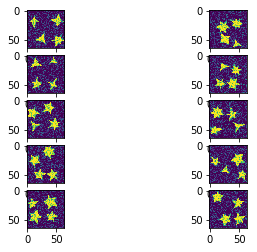

In [24]:
# YOUR CODE HERE

plt.subplot(5, 2, 1)
plt.imshow(np.reshape(x_train[0], (64, 64)))
plt.subplot(5, 2, 2)
plt.imshow(np.reshape(x_train[1], (64, 64)))
plt.subplot(5, 2, 3)
plt.imshow(np.reshape(x_train[4000], (64, 64)))
plt.subplot(5, 2, 4)
plt.imshow(np.reshape(x_train[4001], (64, 64)))
plt.subplot(5, 2, 5)
plt.imshow(np.reshape(x_train[8000], (64, 64)))
plt.subplot(5, 2, 6)
plt.imshow(np.reshape(x_train[8001], (64, 64)))
plt.subplot(5, 2, 7)
plt.imshow(np.reshape(x_train[11000], (64, 64)))
plt.subplot(5, 2, 8)
plt.imshow(np.reshape(x_train[11001], (64, 64)))
plt.subplot(5, 2, 9)
plt.imshow(np.reshape(x_train[14000], (64, 64)))
plt.subplot(5, 2, 10)
plt.imshow(np.reshape(x_train[14001], (64, 64)))


### 3.2 Build and train the model

__Q. Build the model from scratch, again for categorical classification.__

In [25]:
# YOUR CODE HERE
model = Sequential()

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv1', input_shape=img_shape_full))

model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv2'))
# model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
#                  activation='relu', name='layer_conv3'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

# To do regression, use a linear activation for the final dense layer!
model.add(Dense(1, activation='linear'))


In [26]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [27]:
model.fit(x=x_train,
          y=y_train,
          epochs=4, batch_size=100)

Epoch 1/4
15000/15000 [==============================] - 58s 4ms/sample - loss: 576.1383 - mean_absolute_error: 2.8924
Epoch 2/4
15000/15000 [==============================] - 59s 4ms/sample - loss: 0.2342 - mean_absolute_error: 0.3783
Epoch 3/4
15000/15000 [==============================] - 57s 4ms/sample - loss: 0.1740 - mean_absolute_error: 0.3242
Epoch 4/4
15000/15000 [==============================] - 57s 4ms/sample - loss: 0.1641 - mean_absolute_error: 0.3196


### 3.3 Evaluate results

__Q. Evaluate how well your trained network does on the test set. This time there is no minimum accuracy, but the students with the top 3 accuracies in the class gain _extra credit_! (_make sure to save your trained model_)__ 

In [28]:
# YOUR CODE HERE
result = model.evaluate(x=x_test,
                        y=y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

5000/5000 [==============================] - 6s 1ms/sample - loss: 0.1626 - mean_absolute_error: 0.3073
loss 0.1625963798046112
mean_absolute_error 0.30729097


## End

This assignment is over. I hope you've learned a lot and that this will inspire you to come up with your own questions about deep nets, and machine learning in general.
